# Dataset Selection

The objective of this assignment is to perform classification on a real world data. I selected the phonemes dataset, a datset designed for speech recognition tasks in the European ESPRIT 5516 project: ROARS.

The aim of the present database is to distinguish between nasal and oral vowels. There are thus two different classes:

- **Class 0** : Nasals

- **Class 1** : Orals

This database contains vowels coming from 1809 isolated syllables (for example: pa, ta, pan,...). Five different attributes were chosen to characterize each vowel: they are the amplitudes of the five first harmonics AHi, normalised by the total energy Ene (integrated on all the frequencies): AHi/Ene. Each harmonic is signed: positive when it corresponds to a local maximum of the spectrum and negative otherwise.

Three observation moments have been kept for each vowel to obtain 5427 different instances:

- the observation corresponding to the maximum total energy Ene.

- the observations taken 8 msec before and 8 msec after the observation corresponding to this maximum total energy.

From these 5427 initial values, 23 instances for which the amplitude of the 5 first harmonics was zero were removed, leading to the 5404 instances of the present database. The patterns are presented in a random order.

The source of dataset is : https://www.openml.org/search?type=data&sort=runs&status=active&id=1489

But the data file at that location is standardized so it cannot be used to perform train test split, hence I looked for and found the original data file in this github repo : https://github.com/jbrownlee/Datasets/blob/master/phoneme.names

## Importing Needed Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, roc_curve, auc

from sklearn.metrics import log_loss

## Data Loading

In [2]:
path = "/kaggle/input/phoneme2/phoneme.csv"
df = pd.read_csv(path, header=None)
df.columns = ['V1','V2','V3','V4','V5','Class']
df.head()

,V1,V2,V3,V4,V5,Class
0,1.240,0.875,-0.205,-0.078,0.067,0
1,0.268,1.352,1.035,-0.332,0.217,0
2,1.567,0.867,1.300,1.041,0.559,0
3,0.279,0.990,2.555,-0.738,0.000,0
4,0.307,1.272,2.656,-0.946,-0.467,0


In [4]:
# Basic Information
print("First 5 rows of the dataframe:")
df.head()

First 5 rows of the dataframe:


,V1,V2,V3,V4,V5,Class
0,1.240,0.875,-0.205,-0.078,0.067,0
1,0.268,1.352,1.035,-0.332,0.217,0
2,1.567,0.867,1.300,1.041,0.559,0
3,0.279,0.990,2.555,-0.738,0.000,0
4,0.307,1.272,2.656,-0.946,-0.467,0


In [5]:
print("Dataframe information:")
df.info()

Dataframe information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5404 entries, 0 to 5403
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      5404 non-null   float64
 1   V2      5404 non-null   float64
 2   V3      5404 non-null   float64
 3   V4      5404 non-null   float64
 4   V5      5404 non-null   float64
 5   Class   5404 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 253.4 KB


In [6]:
# Check for Missing Values
print("Missing values per column:")
df.isnull().sum()

Missing values per column:


V1       0
V2       0
V3       0
V4       0
V5       0
Class    0
dtype: int64

As there is not any missing values in the data, we can proceed further without accounting for filling or handling missing data.

In [7]:
# Target Variable Distribution
print("Class distribution:")
print(df['Class'].value_counts())

Class distribution:
Class
0    3818
1    1586
Name: count, dtype: int64


### Train - Test Split

In [8]:
df_train, df_test = train_test_split(
    df, 
    test_size=0.2,
    random_state=42,
    stratify=df["Class"]
)

print(f"df_train shape: {df_train.shape}")
print(f"df_test shape: {df_test.shape}")

df_train shape: (4323, 6)
df_test shape: (1081, 6)


In [9]:
X_train = df_train.drop('Class', axis=1)
y_train = df_train['Class']

X_test = df_test.drop('Class', axis=1)
y_test = df_test['Class']

## Explorative Data Analysis

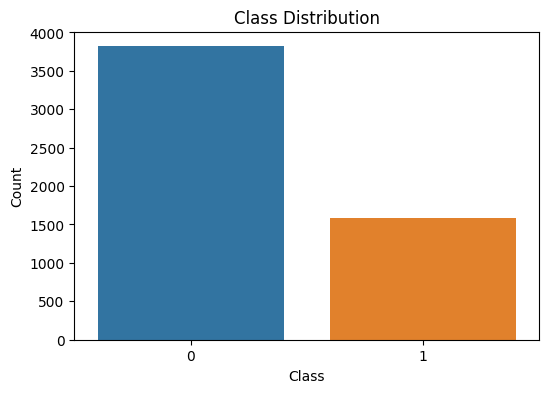

In [10]:
# Plotting class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

1. From the given class distribution we can see that we have unbalanced data, hence we need to resample the train data before training any model on it. Otherwise model will have certain bias towards majority class which is not ideal.

In [11]:
# Getting statistical features of the numeric data columns V1, V2, V3, V4, V5
df.describe()

,V1,V2,V3,V4,V5,Class
count,5404.000000,5404.000000,5404.000000,5404.000000,5404.000000,5404.000000
mean,0.818957,1.258802,0.764732,0.398743,0.078619,0.293486
std,0.858733,0.851057,0.925436,0.796531,0.575624,0.455401
min,-1.700000,-1.327000,-1.823000,-1.581000,-1.284000,0.000000
25%,0.243750,0.596000,-0.115000,-0.205000,-0.232250,0.000000
50%,0.492500,1.075500,0.729000,0.285500,-0.044000,0.000000
75%,1.089250,1.866250,1.484000,0.937000,0.196250,1.000000
max,4.107000,4.378000,3.199000,2.826000,2.719000,1.000000


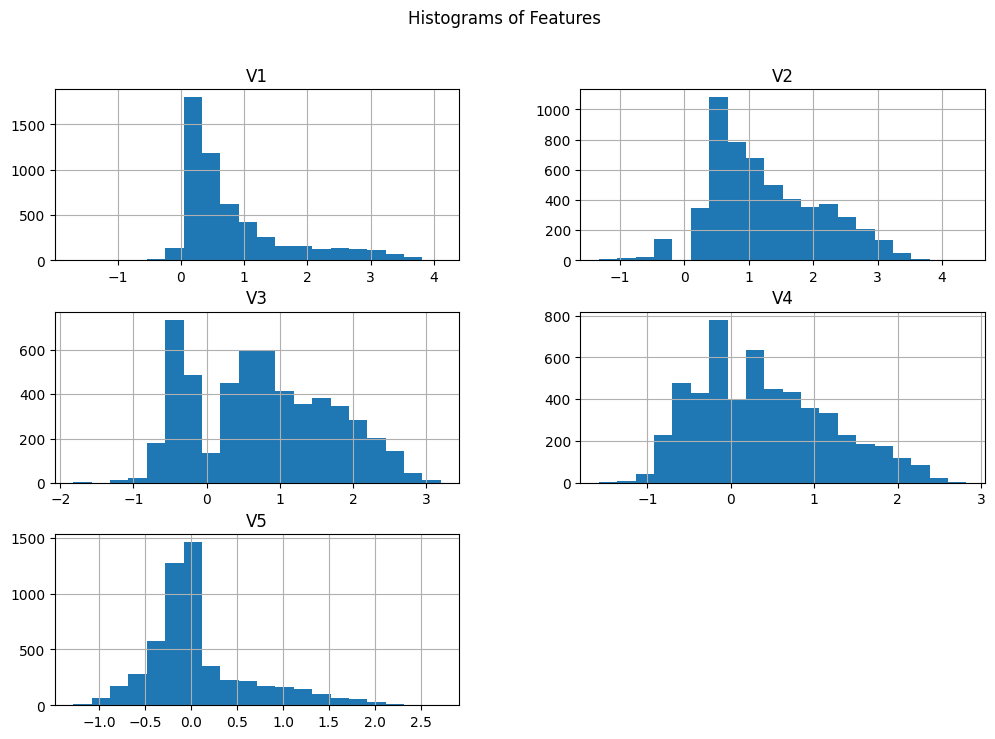

In [12]:
# Histograms for numerical features
df[['V1','V2','V3','V4','V5']].hist(figsize=(12,8), bins=20)
plt.suptitle('Histograms of Features')
plt.show()

2. The scales of numerical features don't vary much but as a measure we can standard scale the features to ensure that model learns well.

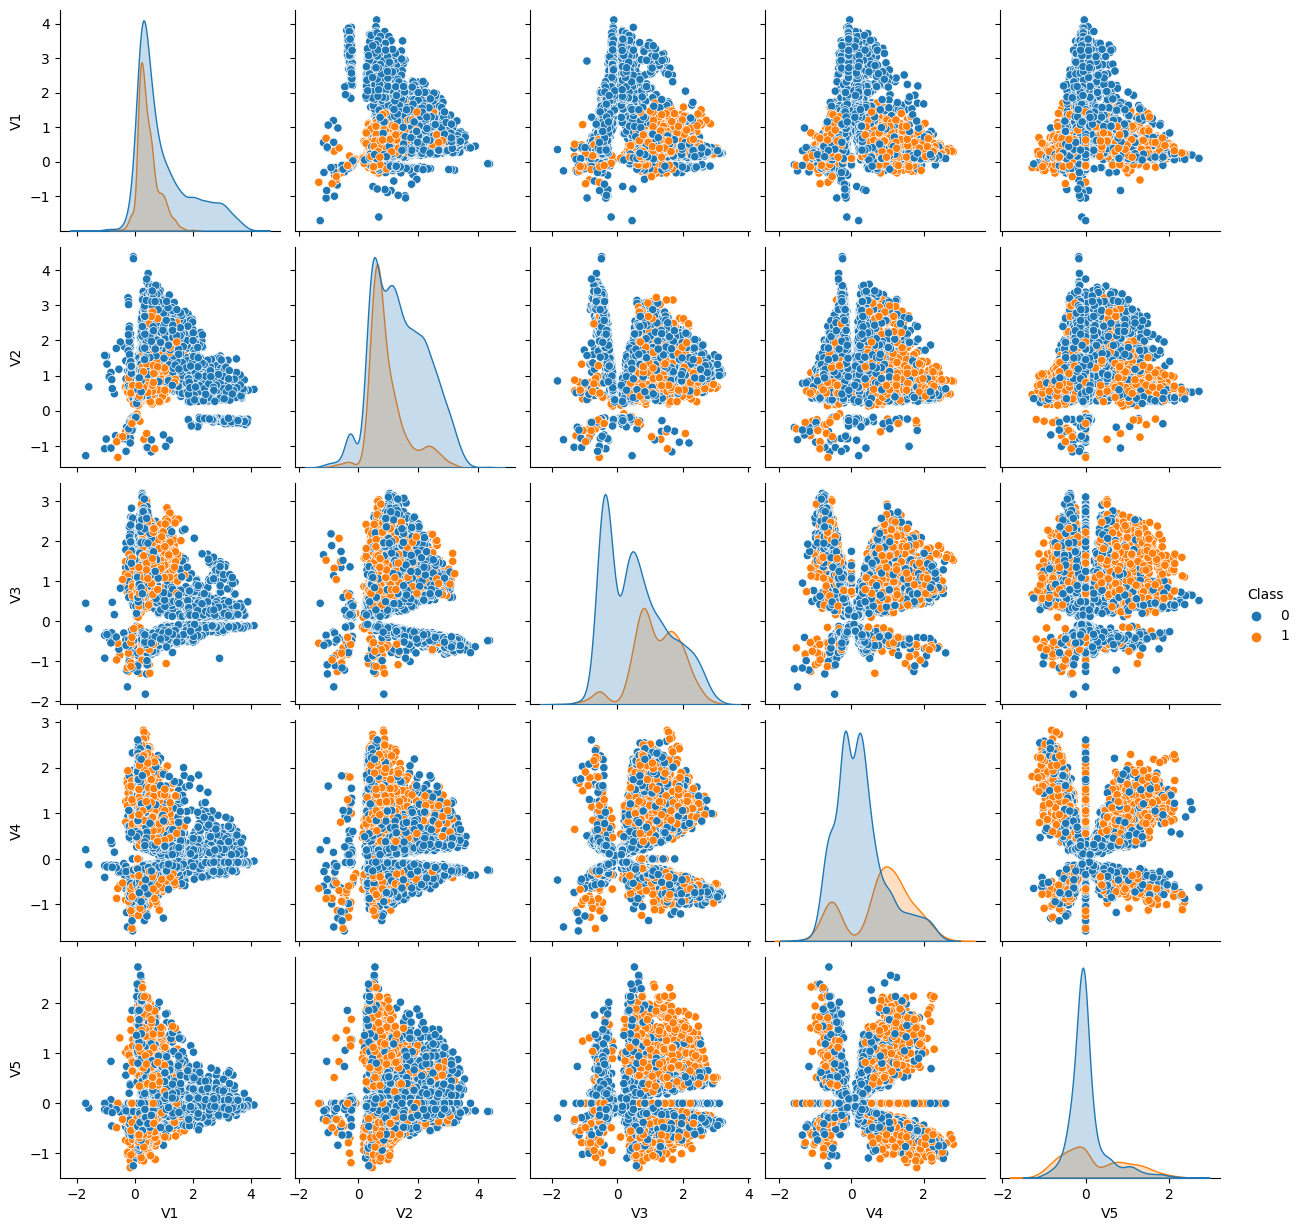

In [13]:
# Pairwise Relationships (select features for clarity)
sns.pairplot(df[['V1','V2', 'V3', 'V4', 'V5','Class']], hue='Class', diag_kind='kde')
plt.show()

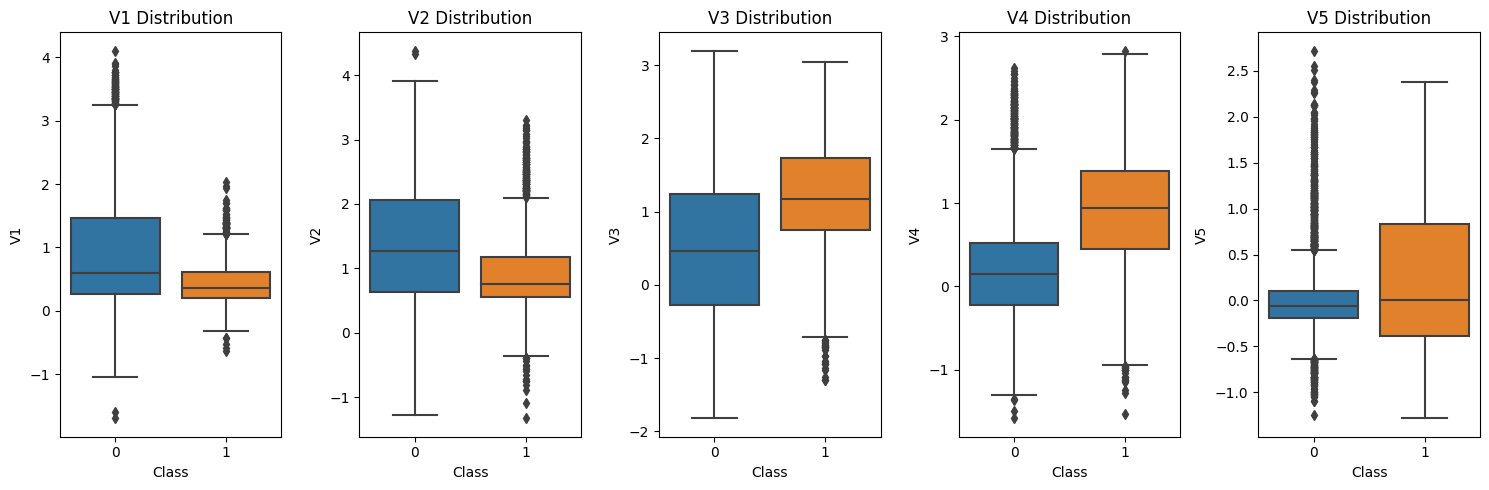

In [14]:
# Distribution of Features by Class

features = ['V1', 'V2', 'V3', 'V4', 'V5']
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(15, 5), tight_layout=True)

for i, feature in enumerate(features):
    sns.boxplot(ax=axes[i], x='Class', y=feature, data=df)
    axes[i].set_title(f'{feature} Distribution')
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

3. The distributions of several variables vary significantly between the two class labels, indicating that it should be possible to achieve meaningful separation between the classes.



### Preprocessing the Data

Before actually implementing the model we need to resample the train data so that any kind of bias is eliminated towrds the majority class.

In [15]:
# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

In [16]:
y_train_oversampled.value_counts()

Class
0    3054
1    3054
Name: count, dtype: int64

In [17]:
# Scaling the data as a preprocessing step
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_oversampled)
X_test_scaled = scaler.transform(X_test)

## Model Implementation

For implementing the model, we have a binary class classification, we will be using a Random Forest Classifier with 5 fold cross validation along with GridSearch CV for finding the hyperparameters.

### Random Forest Classifier with 5 fold CV

In [18]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_classifier = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# Train the model with GridSearchCV
grid_search.fit(X_train_scaled, y_train_oversampled)

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics
print("Best Parameters:", grid_search.best_params_)
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}
Test Set Accuracy: 0.8973172987974098
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.93       764
           1       0.80      0.87      0.83       317

    accuracy                           0.90      1081
   macro avg       0.87      0.89      0.88      1081
weighted avg       0.90      0.90      0.90      1081

[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   2.9s
[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=   4.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=   4.4s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   2.9s
[CV] END max_depth=None, min_samples_split=5, n_estima

### Model Evaluation

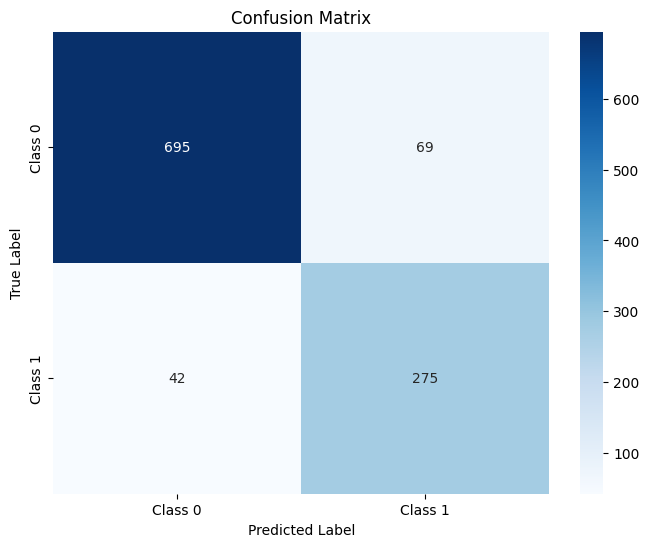

In [19]:
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

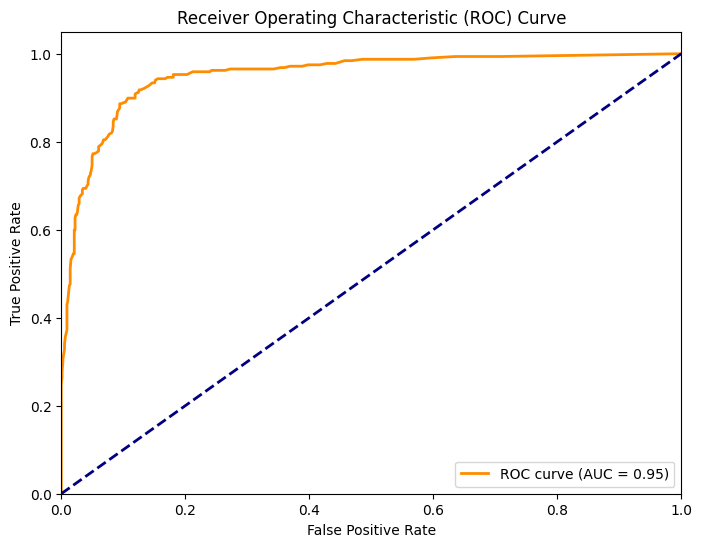

In [20]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Plotting Train - Test Loss against max-depth parameter

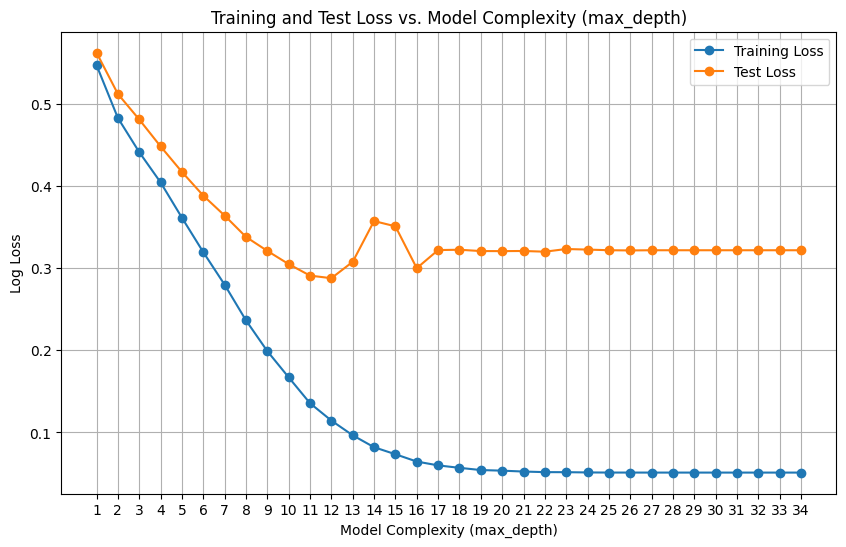

In [21]:
# Define a range for the complexity parameter `max_depth`
max_depth_range = list(range(1,35))

# Initialize lists to store training and test losses
train_losses = []
test_losses = []

# Iterate over the range of `max_depth`
for max_depth in max_depth_range:
    # Train a Random Forest with the current `max_depth`
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=max_depth, random_state=42)
    rf_model.fit(X_train_scaled, y_train_oversampled)
    
    # Predict probabilities for training and test sets
    y_train_pred_proba = rf_model.predict_proba(X_train_scaled)
    y_test_pred_proba = rf_model.predict_proba(X_test_scaled)
    
    # Compute log loss (cross-entropy loss) for training and test sets
    train_loss = log_loss(y_train_oversampled, y_train_pred_proba)
    test_loss = log_loss(y_test, y_test_pred_proba)
    
    # Append losses to the lists
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Plot training and test loss vs. model complexity (`max_depth`)
plt.figure(figsize=(10, 6))
plt.plot([str(d) for d in max_depth_range], train_losses, label='Training Loss', marker='o')
plt.plot([str(d) for d in max_depth_range], test_losses, label='Test Loss', marker='o')
plt.xlabel('Model Complexity (max_depth)')
plt.ylabel('Log Loss')
plt.title('Training and Test Loss vs. Model Complexity (max_depth)')
plt.legend()
plt.grid(True)
plt.show()

## Plot of Bias and Variance vs max-depth (model complexity)

In [25]:
def compute_bias_variance(X, y, model, cv):
    n_samples = X.shape[0]
    n_folds = cv.get_n_splits()
    pred_proba = np.zeros((n_samples, n_folds))
    
    for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train_fold = X[train_idx]
        X_val_fold = X[val_idx]
        y_train_fold = y[train_idx]
        y_val_fold = y[val_idx]
        model.fit(X_train_fold, y_train_fold)
        pred_proba_val = model.predict_proba(X_val_fold)[:,1]
        pred_proba[val_idx, i] = pred_proba_val
    
    expected_pred_proba = np.mean(pred_proba, axis=1)
    bias = expected_pred_proba - y
    variance = np.var(pred_proba, axis=1)
    return bias, variance

Processed max_depth=1
Processed max_depth=2
Processed max_depth=3
Processed max_depth=4
Processed max_depth=5
Processed max_depth=6
Processed max_depth=7
Processed max_depth=8
Processed max_depth=9
Processed max_depth=10
Processed max_depth=11
Processed max_depth=12
Processed max_depth=13
Processed max_depth=14
Processed max_depth=15
Processed max_depth=16
Processed max_depth=17
Processed max_depth=18
Processed max_depth=19
Processed max_depth=20
Processed max_depth=21
Processed max_depth=22
Processed max_depth=23
Processed max_depth=24
Processed max_depth=25
Processed max_depth=26
Processed max_depth=27
Processed max_depth=28
Processed max_depth=29
Processed max_depth=30
Processed max_depth=31
Processed max_depth=32
Processed max_depth=33
Processed max_depth=34


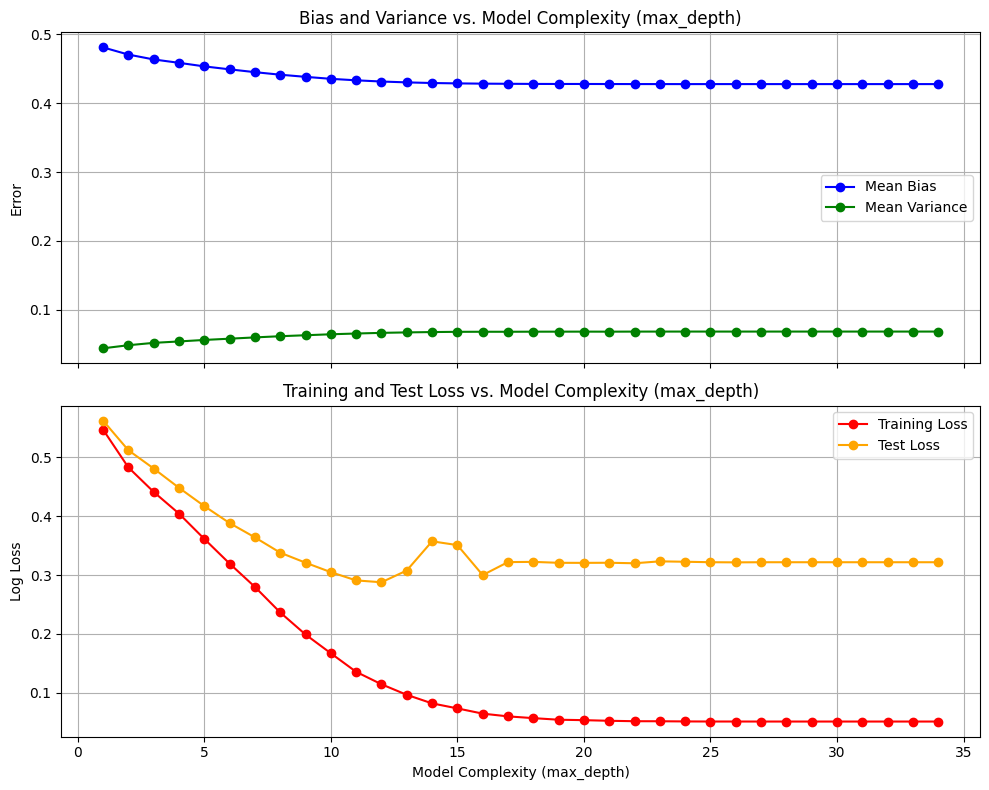

In [26]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
max_depth_range = list(range(1, 35))

mean_bias_list = []
mean_variance_list = []
train_losses = []
test_losses = []

for max_depth in max_depth_range:
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=max_depth, random_state=42)
    
    # Compute bias and variance
    bias, variance = compute_bias_variance(X_train_scaled, y_train_oversampled, rf_model, cv)
    mean_bias = np.mean(np.abs(bias))
    mean_variance = np.mean(variance)
    mean_bias_list.append(mean_bias)
    mean_variance_list.append(mean_variance)
    
    # Compute training and test loss
    rf_model.fit(X_train_scaled, y_train_oversampled)
    y_train_pred_proba = rf_model.predict_proba(X_train_scaled)
    y_test_pred_proba = rf_model.predict_proba(X_test_scaled)
    train_loss = log_loss(y_train_oversampled, y_train_pred_proba)
    test_loss = log_loss(y_test, y_test_pred_proba)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f"Processed max_depth={max_depth}")


# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Bias and Variance subplot
axs[0].plot(max_depth_range, mean_bias_list, label='Mean Bias', marker='o', color='blue')
axs[0].plot(max_depth_range, mean_variance_list, label='Mean Variance', marker='o', color='green')
axs[0].set_ylabel('Error')
axs[0].set_title('Bias and Variance vs. Model Complexity (max_depth)')
axs[0].legend()
axs[0].grid(True)

# Training and Test Loss subplot
axs[1].plot(max_depth_range, train_losses, label='Training Loss', marker='o', color='red')
axs[1].plot(max_depth_range, test_losses, label='Test Loss', marker='o', color='orange')
axs[1].set_xlabel('Model Complexity (max_depth)')
axs[1].set_ylabel('Log Loss')
axs[1].set_title('Training and Test Loss vs. Model Complexity (max_depth)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

The plots are in accordance with the bias variance tradeoff, max_depth is one of the parameters that controls the complexity of the RandomForest Classifiers hence the variance doen't increases that much as it should after a point.